COLAB

In [1]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/MOA_kaggle/'
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/Data/colabs_data/MOA_kaggle/quanvh8_funcs.py' .

Mounted at /content/drive


KAGGLE

In [ ]:
# folder_path = '../input/lish-moa/'
# !cp '../input/coded-file/quanvh8_funcs.py' .

# MODELING

In [3]:
'''ENSEMBLE NETS
Inspire by https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335'''

import numpy as np, pandas as pd, copy, tensorflow as tf, matplotlib.pyplot as plt, sklearn

from tensorflow import feature_column as fc
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (Dense, DenseFeatures, Dropout, 
                                     BatchNormalization, Embedding, Input, Concatenate, Average,
                                     InputLayer, Lambda)
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras import backend as K, Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_addons as tfa
from tensorflow_addons.layers import WeightNormalization

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

from quanvh8_funcs import (DerivedFeatures, kfolds_bagging_training, voting_predict,
                           kolds_stacked_ensemble_training, stacked_ensemble_predict )

import sys

def log_loss_metric(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred).numpy()

print(pd.__version__)
print(tf.__version__)
tf.python.client.device_lib.list_local_devices()

1.1.4
2.3.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7204498311467170958, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10888239155524892650
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2331832617922034768
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15069432608085890274
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
# Loading data and encoding
raw_test = pd.read_csv(folder_path + 'test_features.csv')
raw_train = pd.read_csv(folder_path + 'train_features.csv')
raw_targets = pd.read_csv(folder_path + 'train_targets_scored.csv')
raw_nonscored = pd.read_csv(folder_path + 'train_targets_nonscored.csv')

# Phân loại dữ liệu
cols_id = ['sig_id']
cols_to_remove = ['cp_type']
cols_fts = [i for i in raw_train.columns if i not in cols_id +cols_to_remove]
cols_gene = [col for col in raw_train.columns if col.startswith("g-")]
cols_cell = [col for col in raw_train.columns if col.startswith("c-")]
cols_experiment = [col for col in cols_fts if col not in cols_gene+cols_cell]
cols_target = [i for i in raw_targets.columns if i not in cols_id]
num_fts, num_labels = len(cols_fts), len(cols_target)

# xử lý categorical
def transform_data(input_data):
    '''Clean data and encoding
        * input_data: table '''
    out = input_data.copy()
    out['cp_dose'] = out['cp_dose'].map({'D1':0, 'D2':1})
    out['cp_time'] = out['cp_time']/72
    
    return out

to_train = transform_data(raw_train[raw_train['cp_type'] != 'ctl_vehicle'])
to_train_targets = raw_targets.iloc[to_train.index]
full_pred  = transform_data(raw_test)
to_pred = full_pred[full_pred['cp_type'] != 'ctl_vehicle']

y_train = to_train_targets[cols_target].values
y_non_scored = raw_nonscored.iloc[to_train.index, 1:].values

In [6]:
# PARAMS
u_fts_num = len(cols_fts)
i_fts_num = num_labels

initializer = tf.keras.initializers.LecunNormal()# 'he_normal'  # <-- update
kn_reg = tf.keras.regularizers.l1(2e-7) # <-- update
activation = 'selu'  # <-- update
bias_init_carefully = tf.keras.initializers.Constant(np.log([16844/(21948*206 - 16844)]))


In [7]:
# Define model
def layer_BDWD( n_components, activation = 'relu',  kn_init = 'glorot_uniform', kn_reg = None, bias_init = None):
      def layer_cpl(input_layer):
        '''BN - DROPOUT - WEIGHTNORMAL - DENSE'''
        layer = BatchNormalization() (input_layer)
        layer = Dropout(0.25 ) (layer)
        dense = Dense(n_components, activation = activation, 
                      kernel_initializer = initializer, kernel_regularizer = kn_reg ,
                      bias_initializer = bias_init)
        layer = WeightNormalization(dense) (layer)
        return layer
      return layer_cpl
    
def layer_dense_set(hidden_list):
    def layer_cpl(input_layer):
        layer = input_layer
        for n_hid in hidden_list:
            layer = layer_BDWD(n_hid, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (layer)
        return layer
    return layer_cpl

# Model1 
def model1(n_input, n_output):
    input_u = Input(shape = (n_input,) )
    layer_u = layer_dense_set(hidden_list = [1024, 1024, 512]) (input_u)
    out_put = WeightNormalization(Dense(n_output, activation = 'sigmoid' ))(layer_u)
    model1 =  Model(inputs=[input_u, ], outputs= [out_put])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    bce = tf.keras.losses.BinaryCrossentropy()
    model1.compile(loss= BinaryCrossentropy(), optimizer=opt , metrics= [bce])
    return model1

model_nonscored_rep = model1(n_input = to_train[cols_fts].shape[1], n_output = y_non_scored.shape[1])

In [8]:
# CALLBACK
def exp_decay(lr0, s, down_hill):
    def exp_decay_fn(epoch):
        if epoch <= 5:
            out = lr0*2
        elif epoch%s <= 1:
            out = lr0
        else:
            out = lr0 + 0.015*(epoch%s/ (s - 1))* down_hill/ (down_hill + int(epoch/s) )
        return np.clip( out, 0.001, 0.05)
    return exp_decay_fn

fn_lr = exp_decay(0.001, 5, 50)
lr_schedule = tf.keras.callbacks.LearningRateScheduler ( fn_lr )

reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, mode='min', min_lr=1E-5, verbose= 0)
early_stopping = EarlyStopping(monitor='val_binary_crossentropy', min_delta=1E-5, patience=15, mode='min',restore_best_weights=True, verbose= 0)

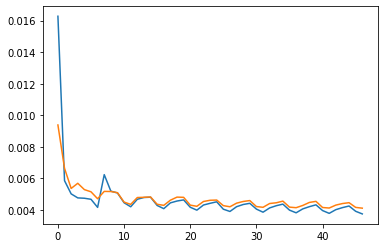

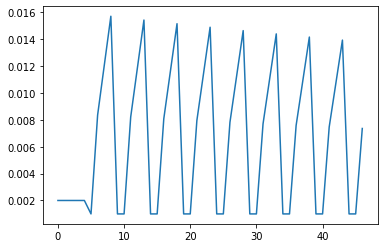

In [9]:
# Add nonscore fts   
history = model_nonscored_rep.fit(
        to_train[cols_fts], y_non_scored, validation_split = 0.25, 
        callbacks=[early_stopping, lr_schedule], epochs= 47, verbose = 0,
        batch_size= 128)

# Graph___________________________________
hí = history.history
đầu_ra = {x: hí[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
plt.plot(pd.DataFrame(đầu_ra))
plt.show()
lr = []
for i in range(47) :
    lr.append( fn_lr(i+1) )
plt.plot(np.array(lr))
plt.show()

In [10]:
# add_fts
X_train = np.concatenate([to_train[cols_fts].values, model_nonscored_rep.predict(to_train[cols_fts])], axis = 1)
X_pred = np.concatenate([to_pred[cols_fts].values, model_nonscored_rep.predict(to_pred[cols_fts])], axis = 1)

In [ ]:
# Train 1st model

model1 = model1(n_input = X_train.shape[1], n_output = y_train.shape[1])

# Fitting
history = model1.fit(
        X_train, y_train, validation_split = 0.25, 
        callbacks=[early_stopping, lr_schedule], epochs= 47, verbose =1,
        batch_size= 128)

# Graph___________________________________
hí = history.history
đầu_ra = {x: hí[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
plt.plot(pd.DataFrame(đầu_ra))
plt.show()
lr = []
for i in range(47) :
    lr.append( fn_lr(i+1) )
plt.plot(np.array(lr))
plt.show()

Epoch 1/47
129/129 [==============================] - 2s 14ms/step - loss: 0.0661 - binary_crossentropy: 0.0386 - val_loss: 0.0581 - val_binary_crossentropy: 0.0317
Epoch 2/47
129/129 [==============================] - 1s 9ms/step - loss: 0.0458 - binary_crossentropy: 0.0201 - val_loss: 0.0450 - val_binary_crossentropy: 0.0199
Epoch 3/47
129/129 [==============================] - 1s 9ms/step - loss: 0.0433 - binary_crossentropy: 0.0188 - val_loss: 0.0432 - val_binary_crossentropy: 0.0191
Epoch 4/47
129/129 [==============================] - 1s 10ms/step - loss: 0.0417 - binary_crossentropy: 0.0180 - val_loss: 0.0423 - val_binary_crossentropy: 0.0190
Epoch 5/47
129/129 [==============================] - 1s 9ms/step - loss: 0.0408 - binary_crossentropy: 0.0177 - val_loss: 0.0414 - val_binary_crossentropy: 0.0185
Epoch 6/47
129/129 [==============================] - 1s 9ms/step - loss: 0.0399 - binary_crossentropy: 0.0173 - val_loss: 0.0407 - val_binary_crossentropy: 0.0184
Epoch 7/47
129

In [ ]:
# KerasFM
def get_list_contains_ohe(keywords, cols_list):
    ouput = []
    for keyword in keywords:
        ouput.append( [1 if keyword in i else 0 for i in cols_list] )
    return ouput

def kerasfm(n_input, n_output, n_components):
    # User embedding
    input_u = Input(shape = (n_input,) )
    layer_u = layer_dense_set(hidden_list = [1024, 1024, n_components]) (input_u)
    layer_u = BatchNormalization() (layer_u)
    
    #Item embedding
      # Addition information for item_info
    list_chem_gr = ['_inhibitor', '_agonist', '_agent', '_antagonist', '_blocker', '_activator']
    chemical_category = tf.transpose( tf.constant( get_list_contains_ohe( list_chem_gr, cols_target  ) ))
      # Full item fts: addition + onehot
    item_ft = tf.concat(
        [chemical_category ,
         tf.eye(i_fts_num, dtype = tf.int32) # Create tensor 0-1 coresponse with chemical labels
        ], axis = 1
    )
    layer_i = WeightNormalization(Dense(n_components, activation = activation, 
                                        kernel_initializer = initializer, kernel_regularizer = kn_reg, 
                                        bias_initializer = bias_init_carefully)) (item_ft)
    layer_i = BatchNormalization() (layer_i)
    
    # Dot product user - item
    def dot_2layer(x):
        return K.dot( x[0], K.transpose(x[1]))
    dot_ui = Lambda( dot_2layer, name = 'lambda_dot' ) ([layer_u,layer_i])
    dot_ui= layer_dense_set(hidden_list = [512] ) (dot_ui)
    
    out_put = WeightNormalization(Dense(n_output, activation = 'sigmoid' ))(dot_ui)
    
    # Compile model
    model =  Model(inputs=[input_u, ], outputs= [out_put])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    bce = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss= bce , optimizer=opt , metrics= [bce])
    
    return model

model_keras_fm = kerasfm(n_input = X_train.shape[1], n_output = y_train.shape[1], n_components = 300)
# NOTE: CÓ REGULARIZATION NÊN KHÔNG KHỚP LOSS - BCE

# Fitting
history = model1.fit(
        X_train, y_train, validation_split = 0.25, 
        callbacks=[lr_schedule], epochs= 47, verbose =1,
        batch_size= 128)

# Graph___________________________________
his_dict = history.history
his_selected = {x: his_dict[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
plt.plot(pd.DataFrame(his_selected))
plt.show()
lr = []
for i in range(47) :
    lr.append( fn_lr(i+1) )
plt.plot(np.array(lr))
plt.show()

In [ ]:
# BAGGING
model_2list = kfolds_bagging_training(7, model1, [], X_train, y_train, bagging_alpha = 0.75, bagging_samples = 5,  callbacks = [early_stopping, lr_schedule]
                                      , epochs = 47, batch_size = 128)
prediction = voting_predict( sum(model_2list, []), X_pred, 206)

0.2

In [ ]:
prediction = voting_predict( sum(model_2list, []), X_pred, 206)
# prediction = model1.predict(X_pred)

df_preds_non_ctl =  pd.DataFrame(prediction, columns= cols_target, index = to_pred.index)

# concat with all to pred values
df_preds = pd.concat([ full_pred[cols_id], df_preds_non_ctl], axis = 1).fillna(0)
# to csv
df_preds.to_csv("submission.csv", index = None)

[0.011,
 0.021,
 0.03,
 0.03,
 0.001,
 0.010803921568627452,
 0.020607843137254903,
 0.03,
 0.03,
 0.001,
 0.010615384615384617,
 0.020230769230769233,
 0.02984615384615385,
 0.03,
 0.001,
 0.010433962264150942,
 0.019867924528301887,
 0.02930188679245283,
 0.03,
 0.001]